###Install Trax and transformers 
Trax is not compatible with Windows 

In [ ]:
!pip install transformers
!pip install trax 

###Import libraries 

In [ ]:
import trax
from trax import layers as tl
import trax.fastmath.numpy as fastnp
from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report ,  matthews_corrcoef , roc_auc_score , confusion_matrix,  roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import copy
import torch
import os
from scipy.spatial import distance
from os import walk
import shutil
from transformers import AutoTokenizer, AutoModel
import nltk
import nltk
nltk.download('punkt')
tokenizerBert = AutoTokenizer.from_pretrained("microsoft/codebert-base")
np.random.seed(123456)
import warnings
warnings.filterwarnings("ignore")

### Import Data

In [ ]:
filenames_v0 = next(walk("./data/test_files_v0" ), (None, None, []))[2] 
filenames_v12 = next(walk("./data/test_files_v12" ), (None, None, []))[2] 


### Transform source code to vectors 

In [ ]:
def get_vocab(folds):
  corpus = set()
  stemmer = nltk.stem.PorterStemmer()
  for tests_path in folds : 
    filenames = next(walk(tests_path ), (None, None, []))[2] 
    for file in filenames : 
        f = open(os.path.join(tests_path, file), 'r', encoding="utf8")
        lines = f.readlines()
        code = ""
        for line in lines :
          if not "@Test"  in line : 
            code = code + " " + " ".join( line.strip().split())
        # use the same tests used with codeBERT 
        code_tokens=tokenizerBert.tokenize( code , return_tensors="pt")
        if(len(code_tokens) < 510) : 
          code = " ".join( code.split("."))
          words= nltk.tokenize.word_tokenize(code)
          stems = set()
          for w in words: 
              stems.add(stemmer.stem(w))
          for w in stems: 
              corpus.add(w)
  return corpus


In [ ]:
def code_to_vector_counts (  tests_path , corpus) : 

  '''
  Inputs
  tests_path : location of code files 
  corpus : vocabulary extracted with the function get_covab()

  Outputs 
  short_tests : Dictionary of test vectors with less than 512 tokens 
  long_tests : Dictionary of test vectors with  more than 512 tokens 
  
  '''

  short_tests = { }
  long_tests  =  {}
  stemmer = nltk.stem.PorterStemmer()
  filenames = next(walk(tests_path ), (None, None, []))[2] 
  for file in filenames : 
    f = open(os.path.join(tests_path, file), 'r', encoding="utf8")
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    lines = f.readlines()
    code = ""
    name = file.split("@")[0]
    for line in lines :
      if not "@Test"  in line : 
          code = code + " " + " ".join( line.strip().split())
    tokens_codebert=tokenizerBert.tokenize( code , return_tensors="pt")
    code = " ".join( code.split("."))
    words = nltk.tokenize.word_tokenize(code)
    stems = []
    vector = []
    for w in words: 
      stems.append(stemmer.stem(w))
    for stem in corpus : 
      vector.append(stems.count(stem))
    if(len(tokens_codebert) < 510) : 
      if ( not label in short_tests.keys() ) :
        short_tests[label] = dict()
      short_tests[label][name] = vector
    else : 
      if ( not label in long_tests.keys() ) :
        long_tests[label] = dict()
      long_tests[label][name] = vector
    f.close()
  return short_tests , long_tests
 

In [ ]:
corpus = get_vocab (["./data/test_files_v0/" , './data/test_files_v12'])

Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
short_data , large_data  = code_to_vector_counts("./data/test_files_v0/" , corpus )

In [ ]:
generated_short_data , generated_large_data = code_to_vector_counts( './data/test_files_v12/', corpus)

## Secondary functions

In [ ]:
# merge a list of dictionaries
def merge_dicts(dict_args):
  '''
  inputs 
  dict_args : list of dictionaries to merge 

  outputs 
  result : merged dictionary

  '''
  result = {}
  for dictionary in dict_args:
    for k , v in dictionary.items() :
      if ( k not in result.keys()):
        result[k] = {}
      for x , y in v.items() :
        result[k][x] = y
  return result


# calculate the cosine similarity
def cos_similarity (x , y ) : 
  '''
  x , y : two vectors with the same dimension
  return the cosine similarity between x and y
  
  '''
  x = normalize(fastnp.array(x))
  y = normalize(fastnp.array(y))
  if(x.ndim > 1 ): 
    return fastnp.diagonal(fastnp.dot(x, y.T) )  
  else :
    return fastnp.dot(x, y.T) 



# nomalize a matrix 
def normalize(x):  
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

# the most frequent element in a list
def most_frequent(List):
    return max(set(List), key = List.count)


# calculate AUC for multi-class problems
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


# divide the data into training and test data 

def divide_data ( X , rate ) : 
  np.random.seed(123456)
  train_data , test_data =  dict() , dict()
  for key , value in X.items() : 
     l = list(value.items())
     np.random.shuffle(l)
     value = dict(l)
     number = int(round(rate*len(value.keys())))
     test_data[key] , train_data[key] = dict(list(value.items())[:number])  ,  dict(list(value.items())[number:])  

  return train_data , test_data 



def shuffle_dict(dic) :
  ls = list(dic.items())
  np.random.shuffle(ls)
  dic = dict(ls)
  return dic

### Filter and split data

In [ ]:
#Consider data with more than 30 examples.
#data use the following  format :  {"flakiness category" : {"testName1" : codeBERT vector , ........} , .......}

data = dict()
for x , y in short_data.items() :
   if len(y) >= 30 : 
     data[x] = y

generated_data= dict()
for x , y in generated_short_data.items() :
   if (x in data.keys()) : 
     generated_data[x] = y

long_data = dict()
for x , y in large_data.items() :
   if (x in data.keys()) : 
     long_data[x] = y

X_train , X_test = divide_data(data , 0.25)


###stratified k-fold

In [ ]:
def K_folds(data_to_divide , folds_number =10) :
  '''
  inputs 
  data_to_divide : dictionary to split into k folds 
  folds_number : number of folds to return 

  outputs 
  folds_tab : list of dictionaries
  
  '''
  folds_tab =   [{} for i in range(folds_number)]
  for k , v in data_to_divide.items() : 
    l = list(v.items())
    np.random.shuffle(l)
    v = dict(l)
    tab_names = np.array_split( list(v.keys()) , folds_number) 
    tab_vectors=  np.array_split( list( v.values() ) , folds_number) 
    for i in range(folds_number) : 
      if ( k not in folds_tab[i].keys()):
        folds_tab[i][k] = dict()
      for j in range(len(tab_names[i])) : 
        folds_tab[i][k][tab_names[i][j]] = tab_vectors[i][j]
  return  folds_tab


### Data generator

In [ ]:
def data_generator(X, batch_size):
    '''
    inputs
    X : data dictionary
    batch_size : number of examples in each batch

    outputs
    batch1 , batch 2 : two batches ready to be used by the Siamese model  

    '''
    batch1 = []
    batch2 = []
    while True:
      for x , y in X.items():
        comb = sample ( list(combinations(  range ( 0 ,len(y.keys()) -1 )  , 2))  ,1 )[0]

        #lines of the same level have data of the same category
        batch1.append( np.array( list(y.values())[comb[0]]).reshape(7283) )
        batch2.append( np.array( list(y.values())[comb[1]]).reshape(7283) )
      if len(batch1) == batch_size:
          yield  np.array(batch1), np.array(batch2) 
          batch1, batch2 = [], [] 


### Siamese model 

In [ ]:
def Siamese( mode='train'):

    def normalize(x):  
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    processor = tl.Serial( 
      
        tl.Dense(512) ,
        tl.Fn('Normalize', lambda x: normalize(x))
    ) 
    
    model = tl.Parallel(processor, processor)
    return model

model = Siamese()

### Triplet loss function

In [ ]:

def TripletLossFn(v1, v2, margin=0.3):

    '''
    v1 , v2 : two matrixes ( batches ) with the same dimension
    return the Triplet Loss between x and y = max( 0 , s(A,closest_negatif) - s(A,P) + margin ) + max( 0 , s(A,mean_negatif) - s(A,P) + margin )

    '''
    v1 = normalize(v1)
    v2 = normalize(v2)
    scores = fastnp.dot(v1, v2.T) 
    batch_size = len(scores)
    positive = fastnp.diagonal(scores) 
    negative_without_positive = scores - 2.0 * fastnp.eye(batch_size) 
    closest_negative = negative_without_positive.max(axis=1)
    negative_zero_on_duplicate = scores * (1.0 - fastnp.eye(batch_size))
    mean_negative = np.sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)
    triplet_loss1 = fastnp.maximum(0.0, margin - positive + closest_negative)
    triplet_loss2 = fastnp.maximum(0.0, margin - positive + mean_negative)
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)
    return triplet_loss


#transform into a trainable function. 
def TripletLoss(margin=0.3):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

### Train function

In [ ]:
def train_model(TripletLoss, sim_margin , lr , n_warmup_steps, train_generator , output_dir):

  '''
  inputs 
  TripletLoss :  loss function
  sim_margin : the similarity margin used in the triplet loss function ( )
  train_generator : training data generator 
  output_dir : dir where to save trained model

  outputs 
  trainning_loop : loop object ready to run for n times and train the model
  
  '''
  lr_schedule = trax.lr.warmup_and_rsqrt_decay( n_warmup_steps, lr)
  train_task = training.TrainTask( 
      labeled_data= train_generator,     
      loss_layer= TripletLoss(sim_margin),      
      optimizer=trax.optimizers.Adam(lr), 
      n_steps_per_checkpoint=1000,       
      lr_schedule=lr_schedule 
    )
    
    
  training_loop = training.Loop(Siamese(),
                                train_task,
                                output_dir=output_dir,
                                random_seed = 123456 )

  return training_loop

### Select support set

In [ ]:

def get_support_set(data , model , number): 
  '''
  inputs 
  data : data to select 
  model :  siamese model to transform the data 
  number : number of examples for each flakiness category

  outputs 
  support_set : selected support_set , the most central data 

  '''
  model_vectors = dict()
  support_set = dict()
  for key , value in data.items():
    model_vectors[key] = {}
    for test in value.keys() : 
      try : 
        v = model(( np.array(data[key][test]) , np.array(data[key][test] )) )[0]
        model_vectors[key][test] = v 
      except : 
        print(data[key][test])

  means_names = {}
  for key , value in model_vectors.items():
    mean_point = np.mean( list(model_vectors[key].values()) , axis=0)
    distances = []
    for cle in value.keys() :  
      distances.append( [ distance.euclidean( mean_point , model_vectors[key][cle]) ,  cle] ) 
    distances.sort(key=lambda tab: tab[0])
    means_names[key] = [ elem[1]  for elem in distances[:number]]
    support_set[key] = dict()
    for Name in means_names[key] : 
      support_set[key][Name] = data[key][Name]

    
  return support_set


### Classifier 

In [ ]:
def smallTestsclassifier(   model,  query  ,  support_set  ):
  '''
  inputs 
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs 
  SimilarityDic : the similarity scores calculated for each category
  label : predicted label 

  '''

  matrix_similarities = []
  SimilarityDic= {}
  for key , value in support_set.items() : 
      y = np.matrix(list(value.values()))
      x1 = [query] * y.shape[0]
      x1 = np.matrix(x1)
      v1, v2 = model( ( x1 , y ) )
      v1 =  normalize(v1)
      v2 = normalize(v2)
      sim = np.dot(v1, v2.T)
      d =   np.mean( np.diag ( sim ))  
      SimilarityDic[key] = d 
  label = max(SimilarityDic, key=SimilarityDic.get)

  return  SimilarityDic , label


In [ ]:
def longTestsClassifier ( model,  query ,  support_set ) :
  '''
  inputs 
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs 
  SimilarityDictionnary : the similarity scores calculated for each category
  most_frequent(labels_predicted) : predicted label 

  '''
  
  labels_predicted =  []
  for TestPart in query : 
    SimilarityDictionnary , label = smallTestsclassifier(model , TestPart  , support_set)
    SimilarityValues  = list ( SimilarityDictionnary.values() )
    SimilarityValues.sort(reverse=True)
    if SimilarityValues[0]  > 0.6 :
      labels_predicted.append(label)
  return  SimilarityDictionnary , most_frequent(labels_predicted)

In [ ]:
def classifier (model,  test_data  ,  support_set) :

  '''
  inputs 
  model : Siamese model
  query : data to classify
  support_set : examples for each category

  outputs 
  predictedLabels : predicted labels for test data
  Sim_matrix : similarity scores 
  '''
  Sim_matrix =  []
  predictedLabels =  [] 
  for query in test_data : 
    if len(query )== 7283  : 
      score , label  = smallTestsclassifier ( model , query , support_set)
    else : 
      score, label  = longTestsClassifier ( model , query , support_set)
    predictedLabels.append(label)
    Sim_matrix.append(score)
  return predictedLabels , Sim_matrix

#Evaluation function

Training in progress ...

=> Training finished
 - Accuracy 0.68
 - Precision :  0.69
 - Recall :  0.68
 - F1 score :  0.67
 - MCC :  0.58
 - AUC :  0.79


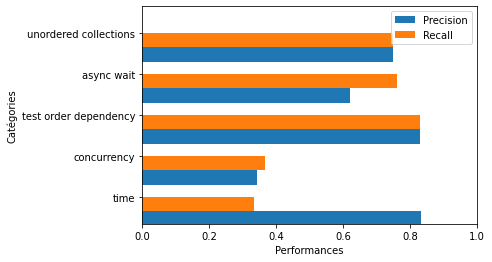

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sim_margin = 0.30
learning_rate = 0.001
batch_size =  len(X_train.keys())
train_steps = 10000
size_support_set = 10
n_warmup_steps = 400
np.random.seed(123456)
test_data = copy.deepcopy(X_test)
train_data = copy.deepcopy (X_train) 
for label , value in generated_data.items() :
  for test_name  , vector in value.items() : 
    if ( test_name[3:] in train_data[label].keys() ) : 
        train_data[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_data[label].keys() ) : 
        test_data[label][test_name] = generated_data[label][test_name]


train_generator = data_generator(train_data, batch_size)
!rm -rf model
training_loop = train_model(TripletLoss,  sim_margin , learning_rate, n_warmup_steps, train_generator , "model/")
print("Training in progress ...")
training_loop.run(train_steps)
print("\n=> Training finished")
#-------------------------------------------------------------------------------
model = Siamese()
model.init_from_file('model/model.pkl.gz')
test_data_array =  []
labels = []
for label , vec in test_data.items():
  test_data_array = test_data_array + list(vec.values())
  labels = labels + [label] * len(list(vec.values()))
unique_labels = list ( set(labels ) )
support_set =  get_support_set(X_train , model , size_support_set)
predicted , sim_scores  = classifier(model , test_data_array  , support_set)

print(' - Accuracy' , np.round(metrics.accuracy_score(labels , predicted ), 2) )
print(' - Precision : ' , np.round( metrics.precision_score(labels , predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels , predicted, average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels , predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels , predicted) , 2) )
print(' - AUC : ' , np.round(multiclass_roc_auc_score(labels , predicted) , 2) )

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Catégories")
plt.show()

## Classical classifiers

In [ ]:
def eval_classifier (model ,  X_to_train , Y_to_train , test_set , test_labels ) : 
  model.fit( X_to_train , Y_to_train)
  y_pred = model.predict(test_set )
  #print(classification_report(test_labels , y_pred))
  print(' - Accuracy' , np.round(metrics.accuracy_score(test_labels , y_pred), 2) )
  print(' - Precision : ' , np.round( metrics.precision_score(test_labels , y_pred , average='weighted') , 2))
  print(' - Recall : ' , np.round( metrics.recall_score(test_labels , y_pred, average='weighted') , 2))
  print(' - F1 score : ' , np.round( metrics.f1_score(test_labels , y_pred , average='weighted') , 2))
  print(' - MCC : ' , np.round( metrics.matthews_corrcoef(test_labels , y_pred) , 2) )
  print(' - AUC : ' , np.round(multiclass_roc_auc_score(test_labels , y_pred) , 2) )
  unique_labels = list ( set(test_labels  ) )
  ind = np.arange(len(unique_labels)) 
  width = 0.35
  fig, ax = plt.subplots()
  precision = metrics.precision_recall_fscore_support(test_labels,  y_pred ,  labels=unique_labels )[0]
  recall = metrics.precision_recall_fscore_support(test_labels, y_pred ,  labels=unique_labels )[1]
  ax.barh(ind - width/2, precision, width, label='Precision')
  ax.barh(ind + width/2, recall, width, label='Recall')
  ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
  ylim=[2*width - 1, len(ind)])
  plt.xlim(0,1)
  ax.legend(loc='upper right')
  ax.set_xlabel("Performances")
  ax.set_ylabel("Catégories")
  plt.show()
#---------------------------------------------------------------------------------------------------------
test_set = copy.deepcopy(X_test)
train_set = copy.deepcopy (X_train) 
for label , value in generated_data.items() :
  for test_name  , vector in value.items() : 
    if ( test_name[3:] in train_set[label].keys() ) : 
        train_set[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_set[label].keys() ) : 
        test_set[label][test_name] = generated_data[label][test_name]

test_labels = []
test_set_to_array =  []
for label , vec in test_set.items():
  test_set_to_array= test_set_to_array + list(vec.values())
  test_labels  = test_labels  + [label] * len(list(vec.values()))
set_labels = list ( set(test_labels  ) )

X_to_train , Y_to_train =  [] , []
for label , values in train_data.items() :
        X_to_train = X_to_train + list(values.values())
        Y_to_train = Y_to_train + [label]*len(values.values())

### RF

 - Accuracy 0.61
 - Precision :  0.72
 - Recall :  0.61
 - F1 score :  0.56
 - MCC :  0.49
 - AUC :  0.72


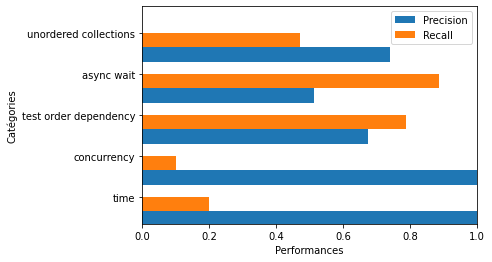

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=123456)

eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)


### DT

 - Accuracy 0.53
 - Precision :  0.53
 - Recall :  0.53
 - F1 score :  0.52
 - MCC :  0.39
 - AUC :  0.69


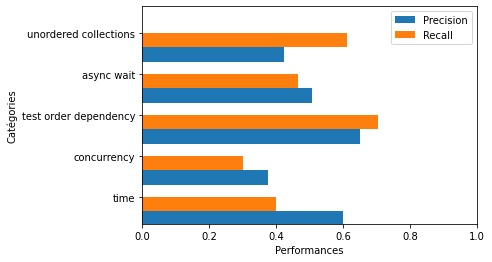

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

###KNN

 - Accuracy 0.48
 - Precision :  0.44
 - Recall :  0.48
 - F1 score :  0.45
 - MCC :  0.31
 - AUC :  0.65


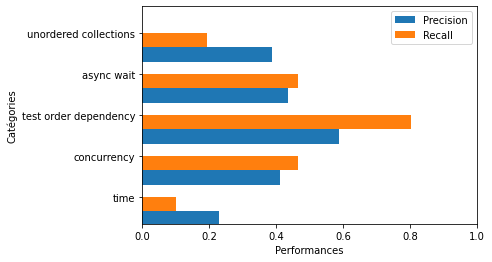

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier() 
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

### SVM

 - Accuracy 0.52
 - Precision :  0.61
 - Recall :  0.52
 - F1 score :  0.45
 - MCC :  0.37
 - AUC :  0.66


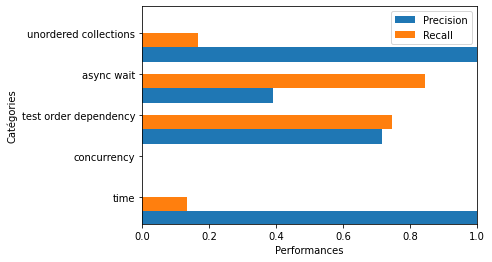

In [ ]:
from sklearn import svm
model = svm.SVC( C = 1. , kernel = 'rbf' , gamma  = 0.01)
eval_classifier (model , X_to_train , Y_to_train ,test_set_to_array , test_labels)